In [37]:
import tf_freq_id
import tracetools as tt
import matplotlib.pyplot as plt 
import numpy as np
import control as ctrl
from utils import *

ast = tt.parse_autotune_file(r'AST files\AST_AX7.xml')
s = ctrl.tf('s')

array([[list([<matplotlib.lines.Line2D object at 0x0000027DDA623A40>])],
       [list([<matplotlib.lines.Line2D object at 0x0000027DD94B9BB0>])]],
      dtype=object)

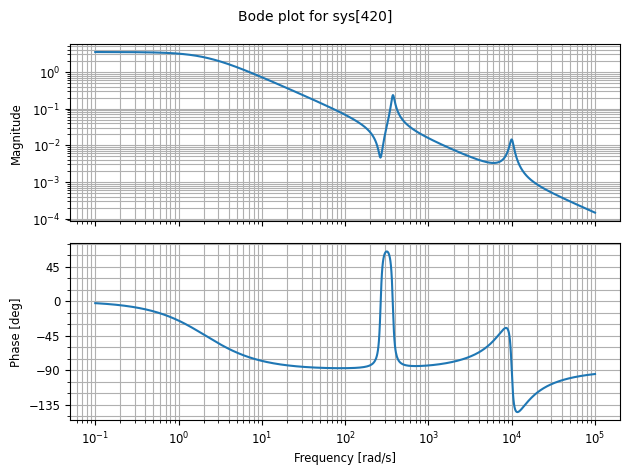

In [38]:

Gf = tf_from_txt(r'tf_txt\Gf.txt')

ctrl.bode(Gf)


In [39]:
Gf

TransferFunction(array([1.44707431e+01, 1.45028212e+05, 1.45130879e+09, 4.23448421e+10,
       1.02667459e+14]), array([1.00000000e+00, 1.03286306e+03, 1.00172763e+08, 3.42649872e+09,
       1.39902598e+13, 2.93312048e+13]))

# IMC Controller

0 states have been removed from the model


TransferFunction(array([98696.04401089]), array([1.00000000e+00, 4.44221201e+02, 9.86960440e+04]))

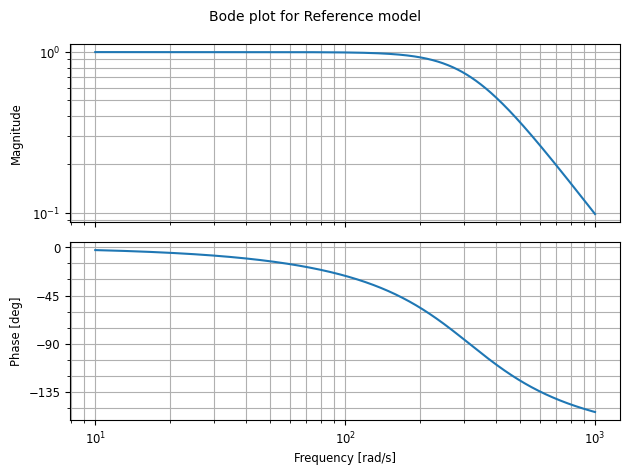

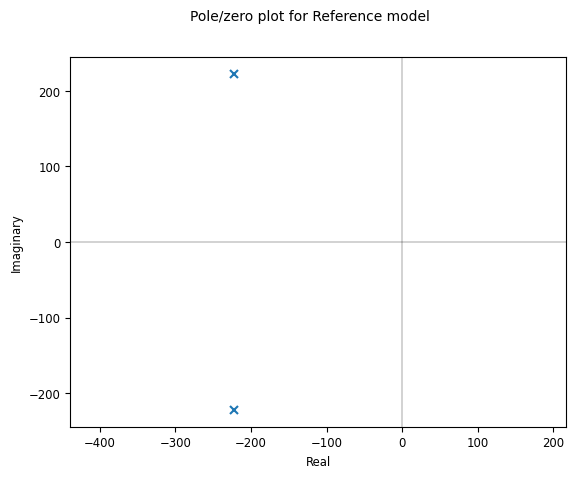

In [40]:

# Ref model
w_cl_m = 50*2*np.pi
#M = 1/(s/w_cl_m + 1)
M = pt2(w_cl_m,0.707)
M = ctrl.minreal(M)
M *= 1/M.dcgain()

M.name = 'Reference model'
ctrl.bode(M)

plt.figure()

ctrl.pzmap(M)

M

In [41]:
def increase_damping(C,min_dampng):

    new_pole_poly = 1.0

    eps = 1e-6

    for z in C.poles():

        # Singe or complez pole?
        p = 1.0
        if np.abs(np.imag(z)) < eps:
            # real pole     
            
            z = np.real(z)
            if np.abs(z) > eps:
                p = (s-z)/(-z)
                p = (s/np.abs(z) + 1)
            else:
                p = (s-z)
        elif np.imag(z) > eps:


            w0 = np.sqrt(np.real(z)**2 + np.imag(z)**2)
            zeta = -np.real(z)/w0

            zeta = max(zeta,min_dampng)

            p = (s**2 + 2*zeta*w0*s + w0**2)/w0**2

        new_pole_poly *= p

    zero_poly = ctrl.tf(C.num[0][0],1)
    C_new = zero_poly/new_pole_poly


    gain0 = ctrl.frequency_response(C).response[0][0]
    gain0 = np.mean(np.abs(gain0))

    gain1 = ctrl.frequency_response(C_new).response[0][0]
    gain1 = np.mean(np.abs(gain1))

    C_new *= gain0/gain1


    return C_new


    



2 states have been removed from the model


TransferFunction(array([6.82038533e+03, 7.04452407e+06, 6.83216844e+11, 2.33700416e+13,
       9.54189628e+16, 2.00050119e+17]), array([1.00000000e+00, 1.04663888e+04, 1.04744683e+08, 4.74783480e+10,
       8.39472685e+12, 3.15167380e+15, 0.00000000e+00]))

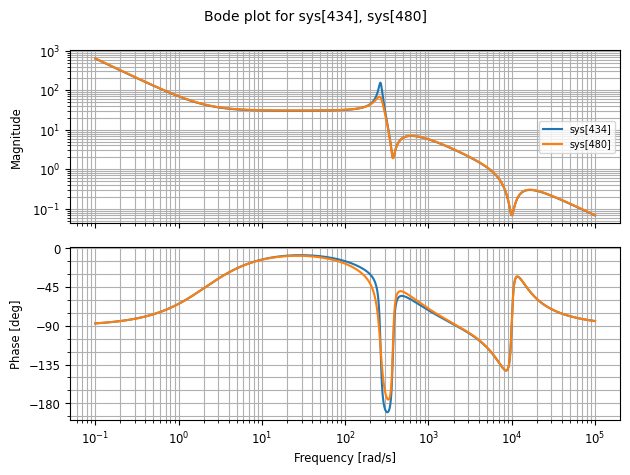

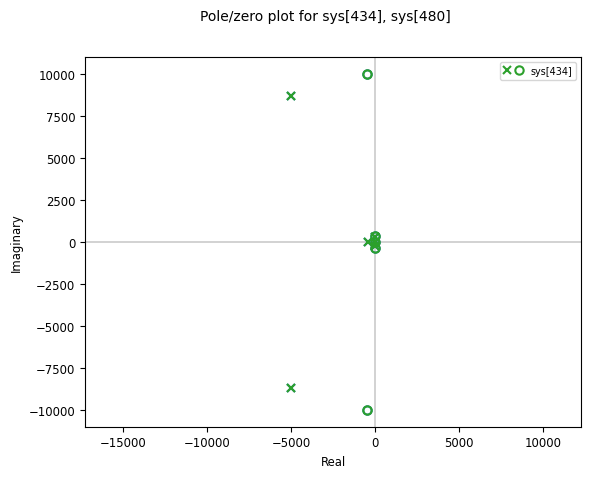

In [42]:
C_imc = M/(1-M) * (1/Gf)
C_imc = ctrl.minreal(C_imc)

ctrl.bode(C_imc)

if True:
    C_imc2 = increase_damping(C_imc,0.1)
    ctrl.bode(C_imc2)

plt.figure()
ctrl.pzmap(C_imc)
ctrl.pzmap(C_imc2)

C_imc


In [43]:

with open(r'tf_txt\C_imc.txt','w') as f:
    print_tf(C_imc,f)

with open(r'tf_txt\C_imc2.txt','w') as f:
    print_tf(C_imc2,f)

9 states have been removed from the model
7 states have been removed from the model
2 states have been removed from the model
4 states have been removed from the model


array([[list([<matplotlib.lines.Line2D object at 0x0000027DD9604A10>])],
       [list([<matplotlib.lines.Line2D object at 0x0000027DD9606BA0>])]],
      dtype=object)

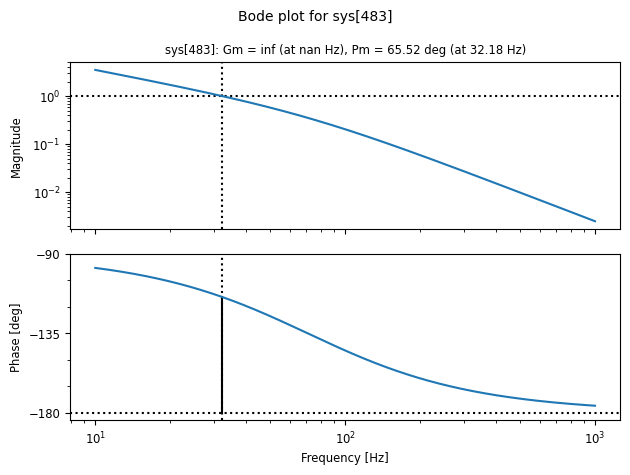

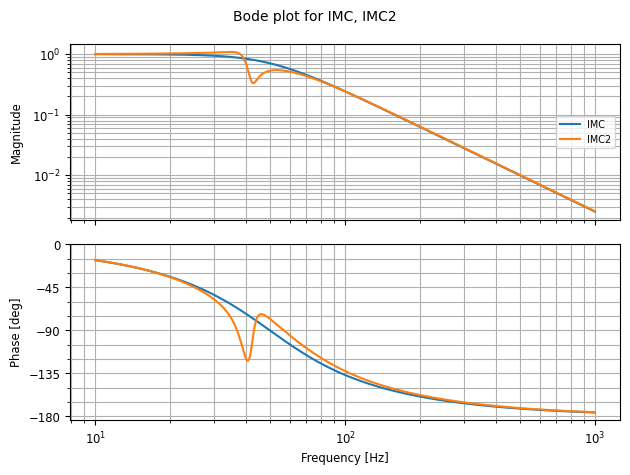

In [44]:
L_imc = C_imc*Gf
L_imc = ctrl.minreal(L_imc)

L_imc2 = C_imc2*Gf
L_imc2 = ctrl.minreal(L_imc2)

ctrl.bode(L_imc,display_margins=True,Hz=True)

CL_imc = L_imc/(1+L_imc)
CL_imc = ctrl.minreal(CL_imc)
CL_imc.name = 'IMC'

CL_imc2 = L_imc2/(1+L_imc2)
CL_imc2 = ctrl.minreal(CL_imc2)
CL_imc2.name = 'IMC2'

plt.figure()
ctrl.bode(CL_imc,Hz=True)
ctrl.bode(CL_imc2,Hz=True)


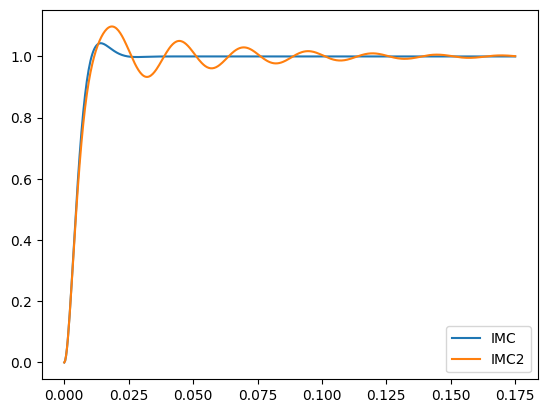

In [45]:
tv = np.linspace(0,0.175,500)

t,y = ctrl.step_response(CL_imc,T=tv)
t2,y2 = ctrl.step_response(CL_imc2,T=tv)
plt.figure()
plt.plot(t,y)
plt.plot(t2,y2)
plt.legend(['IMC','IMC2'])

0 states have been removed from the model


array([[list([<matplotlib.lines.Line2D object at 0x0000027DD93FE4B0>])],
       [list([<matplotlib.lines.Line2D object at 0x0000027DD93FE6F0>])]],
      dtype=object)

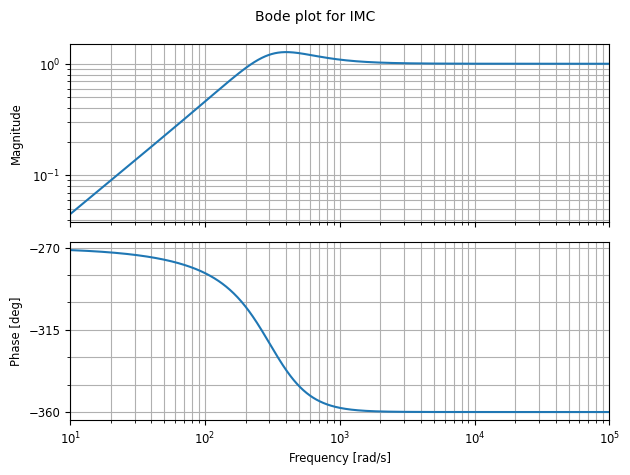

In [46]:


S_imc = 1/(1+L_imc)

S_imc = ctrl.minreal(S_imc)

S_imc.name = 'IMC'

omega_lim = [10,1e5]

ctrl.bode(S_imc,omega_limits=omega_lim)